In [1]:
# Author : T.Lecae - INRAE - US-ODR
# Date : 09/03/2023
#######
## Code executed using Gis_1 environment
## The environment may be reproduced using $ conda create --name <env> --file requirements.txt
## Create requirement.txt using :: conda list -e > requirements.txt
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from rasterio.mask import mask
from scipy.stats import entropy
from scipy import ndimage
import os

In [2]:
## Define directories


# Get the path to the parent directory
parent_directory = os.path.abspath(os.path.join(os.getcwd(), ".."))
#### Data dir
# Construct the path to the data directory
data_directory = os.path.join(parent_directory, "data")
# Create the directory if it doesn't exist
if not os.path.exists(data_directory):
    os.mkdir(data_directory)
#### Output dir
# Construct the path to the data directory
output_directory = os.path.join(parent_directory, "output")
# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

print(output_directory)

c:\_DEV\test\landscape_metrics\landscape_metrics_home\home_diversity_index\output


In [3]:
## Definition de quelques fonctions permettant de calculer des indices de diversité. Diversité brute de pixels mais aussi pour certaines prenant en compte les patches. 
## Elles seront appliquées itterativement aux "morceaux" d'OSO découpés par les polygones de parcelles du RPG

def count_landcover_patches(masked):
    """
     @brief Count the patches (defined as contiguous cells having the same digital number) in a landcover raster
     @param raster An array
     @return The number of patches in the raster
    """
    # Get the unique landcover classes in the raster.
    classes = np.unique(masked)
    # Initialize a variable to store the total number of patches.
    patch_count = 0
    # Loop over each landcover class.
    # This function will label the connected regions of the current class.
    for c in classes:
        # Create a binary mask for the current class.
        binary_raster = np.where(masked == c, 1, 0)
        # Label the connected regions in the binary mask.
        labeled_raster, num_labels = ndimage.label(binary_raster)
        # Count the number of patches with contiguous cells of the same class.
        for i in range(1, num_labels + 1):
            patch_mask = labeled_raster == i
            # If patch_mask is not empty it will increment patch count.
            if patch_mask.any():
                patch_count += 1
    return patch_count

#Landscape Division Index
def calc_ldi(masked):
    """
     @brief Calculate the LDI of a set of cells. This is a measure of how much the cell is in the data set but not the area of the cell that is used to calculate the distance between the cell and its neighboring cells
     @param masked A 2D NumPy array with shape ( nb_cells num_cells )
     @return An LDI value between 0 and 1 ( inclusive ). The value is calculated as the standard deviation divided by the mean
    """
    # Calculate the standard deviation of cell values
    std = np.std(masked.flatten())
    # Calculate the mean of cell values
    mean = np.mean(masked.flatten())
    # Calculate the LDI
    ldi = std / mean
    return ldi

## Patch Cohesion Index
def calc_pci(masked):
    """
     @brief Calculate the PCI for a set of images. This is based on the number of patches and perimeter
     @param masked Masked image to calculate the PCI for
     @return pci The PCI for the image as a function of the number of patches and perimeter ( float
    """
    # Calculate the Patch Cohesion Index (PCI)
    # Returns the sum of masked masked values.
    if np.sum(masked) == 0:
        return 0.0

    # Calculate the number of patches
    label_im, nb_labels = ndimage.label(masked)
    # Returns the number of labels.
    if nb_labels == 1:
        return 1.0

    # Calculate the total perimeter
    perimeter = np.sum(ndimage.binary_dilation(masked) & ~masked)

    # Calculate the perimeter for each patch
    patch_perimeter = np.zeros(nb_labels, dtype=np.float64)
    # Calculate patch perimeter for each label.
    for label in range(1, nb_labels + 1):
        mask_label = label_im == label
        patch_perimeter[label - 1] = np.sum(ndimage.binary_dilation(mask_label) & ~mask_label)

    # Calculate the average patch perimeter
    avg_patch_perimeter = np.sum(patch_perimeter) / nb_labels

    # Calculate the PCI
    pci = (perimeter - avg_patch_perimeter) / perimeter

    return pci

## Contagion Index 
def calc_contag(masked):
    """
     @brief Calculate the contagion index of a mask. This is based on the proportion of the patches in the mask divided by the total area
     @param masked The mask to calculate the contagion index for
     @return The contagion index of the mask as a function of the area of the image and the proportion
    """
    # Calculate the Contagion Index (CONTAG)
    # Returns the sum of masked masked values.
    if np.sum(masked) == 0:
        return 0.0

    # Calculate the number of patches
    label_im, nb_labels = ndimage.label(masked)
    # Returns the number of labels.
    if nb_labels == 1:
        return 0.0

    # Calculate the total area
    total_area = masked.size

    # Calculate the area for each patch
    patch_area = np.zeros(nb_labels, dtype=np.float64)
    # Calculate the patch area for each label
    for label in range(1, nb_labels + 1):
        mask_label = label_im == label
        patch_area[label - 1] = np.sum(mask_label)

    # Calculate the proportion of each patch
    patch_prop = patch_area / total_area

    # Calculate the CONTAG
    contag = -np.sum(patch_prop * np.log(patch_prop))

    return contag

## Landscape Shape Index
def calc_lsi(masked):
    """
     @brief Calculate LSI for a landcover raster. This is based on the proportion of pixels in each row and column that have landcover.
     @param lc The landcover raster to calculate lsi for.
     @return The LSI for the raster as a 1 - ( var ( row ) + var ( column ))
    """
    # convert landcover raster to binary (1 = landcover class present, 0 = landcover class absent)
    binary_lc = np.where(masked > 0, 1, 0)
    
    # calculate the proportion of pixels in each row and column that have landcover
    row_prop = np.mean(binary_lc, axis=1)
    col_prop = np.mean(binary_lc, axis=0)
    
    # calculate row and column variance
    row_var = np.var(row_prop)
    col_var = np.var(col_prop)
    
    # calculate LSI
    lsi = 1 - (row_var + col_var)
    
    return lsi

## Patch Richness Index
def calc_pri(masked):
    """
     @brief Calculate pri for landcover. This is based on the number of patches and total area for each class
     @param lc numpy array of landcover classes
     @return pri ( float ) : pri for landcover in range 0.. 1 where 0 is no patches and 1 is
    """
    # get unique landcover classes
    classes = np.unique(masked)
    
    # calculate the number of patches and total area for each class
    num_patches = []
    total_area = []
    # Add the number of patches and labels for each class.
    for c in classes:
        binary_lc = np.where(masked == c, 1, 0)
        num, labels = ndimage.label(binary_lc)
        num_patches.append(num)
        total_area.append(np.sum(binary_lc))
    
    # calculate PRI
    pri = np.sum([num_patches[i] * total_area[i] for i in range(len(classes))]) / np.sum(total_area)
    
    return pri

## Interspersion and Juxtaposition Index
def calc_iji(masked):
    """
     @brief Calculate the number of neighboring pixels with different landcover classes. This is used to calculate the i. i. d.
     @param lc The landcover raster of the same shape as the grid
     @return The number of neighboring pixels with different landcover classes in the grid as a 1x1 np
    """
    # convert landcover raster to binary (1 = landcover class present, 0 = landcover class absent)
    binary_lc = np.where(masked > 0, 1, 0)
    
    # calculate the number of adjacent pixels with different landcover classes
    iji = np.sum(np.abs(np.diff(binary_lc, axis=0))) + np.sum(np.abs(np.diff(binary_lc, axis=1)))
    
    return iji



In [4]:
# Load the raster data and vector data
with rasterio.open(os.path.join(data_directory, "oso_2021_2_2154.tif")) as src:
    # print("connection_meta : " , src.meta)
    raster = src.read(1)
    polygons = gpd.read_file(os.path.join(data_directory, "rpg_cplt.shp"))
    # print('type', )
    ## Create a new columns to store the class diversity indexes and other infos
    polygons['cells_numb'] = np.nan
    polygons['class_numb'] = np.nan
    polygons['patch_numb']= np.nan

    # "simple" diversity indices
    polygons['class_diversity'] = np.nan
    polygons['shannon_diversity'] = np.nan
    polygons['simpson_diversity'] = np.nan
    polygons['jaccard_diversity'] = np.nan
    polygons['shannon_evenness'] = np.nan
    polygons['dominance_index'] = np.nan
    
    # other indexes
    polygons['contag_index'] = np.nan
    polygons['ldi'] = np.nan
    # Patch based indexes
    polygons['patch_cohesion_index'] = np.nan
    polygons['lsi']=np.nan
    polygons['pri']=np.nan
    polygons['iji']=np.nan

    # Loop through each polygon
    # This function will extract the polygon from the raster and extract the polygon geometry and mask the raster with the polygon.
    for index, polygon in polygons.iterrows():
        # Extract the geometry of the polygon
        geom = polygon.geometry
        # Mask the raster with the polygon geometry
        masked, transform = rasterio.mask.mask(src, [geom], crop=True)
        # Compute basic informations
        cell_values = np.unique(masked.flatten())
        # counts = np.bincount(masked.flatten())
        # print('bincount : ', counts)
        unique, counts = np.unique(masked, return_counts=True)
        total_cells = np.sum(counts)
        patch_numb = count_landcover_patches(masked)
        filter_arr = unique > 0
        class_numb = unique[filter_arr].size

       # Calculate "basics" diversity indexes
        shannon_diversity = -np.sum([(count/total_cells) * np.log2(count/total_cells) for count in counts if count > 0])
        simpson_diversity = 1 - np.sum([(count/total_cells)**2 for count in counts])
        diversity_index = np.sum(np.square(counts/total_cells))
        # Calculate Shannon evenness index
        if (np.log2(class_numb)>1):
            shannon_evenness = shannon_diversity / np.log2(class_numb)
        else : 
            shannon_evenness = '1 seule classe'
        # Calculate dominance index
        dominance_index = np.max(counts) / total_cells
        # Calculate Landscape Division Index (LDI)
        ldi = calc_ldi(masked)
        ## Patch based indexes
        # Patch Cohesion index
        pci = calc_pci(masked)
        # Calc contagion index
        contag = calc_contag(masked)
        # Landscape Shape Index
        lsi = calc_lsi(masked)
        # Patch Richness Index
        pri = calc_pri(masked)
        # Interspersion and Juxtaposition Index
        iji = calc_iji(masked)
        
        ## Store computed data 
        # Store basic information about the mask (cell number, classes number)
        polygons.loc[index, 'cells_numb'] = total_cells
        polygons.loc[index, 'class_numb'] = class_numb
        polygons.loc[index, 'patch_numb'] = patch_numb
        # Store the diversity indices in the new columns
        polygons.loc[index, 'shannon_diversity'] = shannon_diversity
        polygons.loc[index, 'simpson_diversity'] = simpson_diversity
        polygons.loc[index, 'class_diversity'] = diversity_index
        polygons.loc[index, 'shannon_evenness'] = shannon_evenness
        # Store the dominance index and LDI in the new columns
        polygons.loc[index, 'dominance_index'] = dominance_index
        polygons.loc[index, 'ldi'] = ldi
        # Patch based indexes
        polygons.loc[index,'patch_cohesion_index'] = pci
        polygons.loc[index, 'lsi'] = lsi
        polygons.loc[index, 'pri'] = pri
        polygons.loc[index, 'iji'] = iji
        polygons.loc[index, 'contag_index'] = contag
    
    # Enlight polygons by keeping only interesting columns 
    light_polygons = polygons[[ 'geometry','cells_numb','class_numb', 'shannon_diversity', 'simpson_diversity', 'class_diversity', 'shannon_evenness', 'dominance_index', 'ldi', 'contag_index',  'patch_cohesion_index', 'lsi', 'pri', 'iji', 'patch_numb']] 
    # Save the polygon data to a GeoJSON file
    light_polygons.to_file(os.path.join(output_directory, "polygons.json"), driver='GeoJSON', index=True)


C:\Users\tlecae\AppData\Local\Temp\ipykernel_18796\307612480.py:51: RuntimeWarning: divide by zero encountered in log2
  if (np.log2(class_numb)>1):
C:\Users\tlecae\AppData\Local\Temp\ipykernel_18796\287779279.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ldi = std / mean
C:\Users\tlecae\AppData\Local\Temp\ipykernel_18796\307612480.py:51: RuntimeWarning: divide by zero encountered in log2
  if (np.log2(class_numb)>1):
C:\Users\tlecae\AppData\Local\Temp\ipykernel_18796\287779279.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ldi = std / mean
C:\Users\tlecae\AppData\Local\Temp\ipykernel_18796\307612480.py:51: RuntimeWarning: divide by zero encountered in log2
  if (np.log2(class_numb)>1):
C:\Users\tlecae\AppData\Local\Temp\ipykernel_18796\287779279.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ldi = std / mean



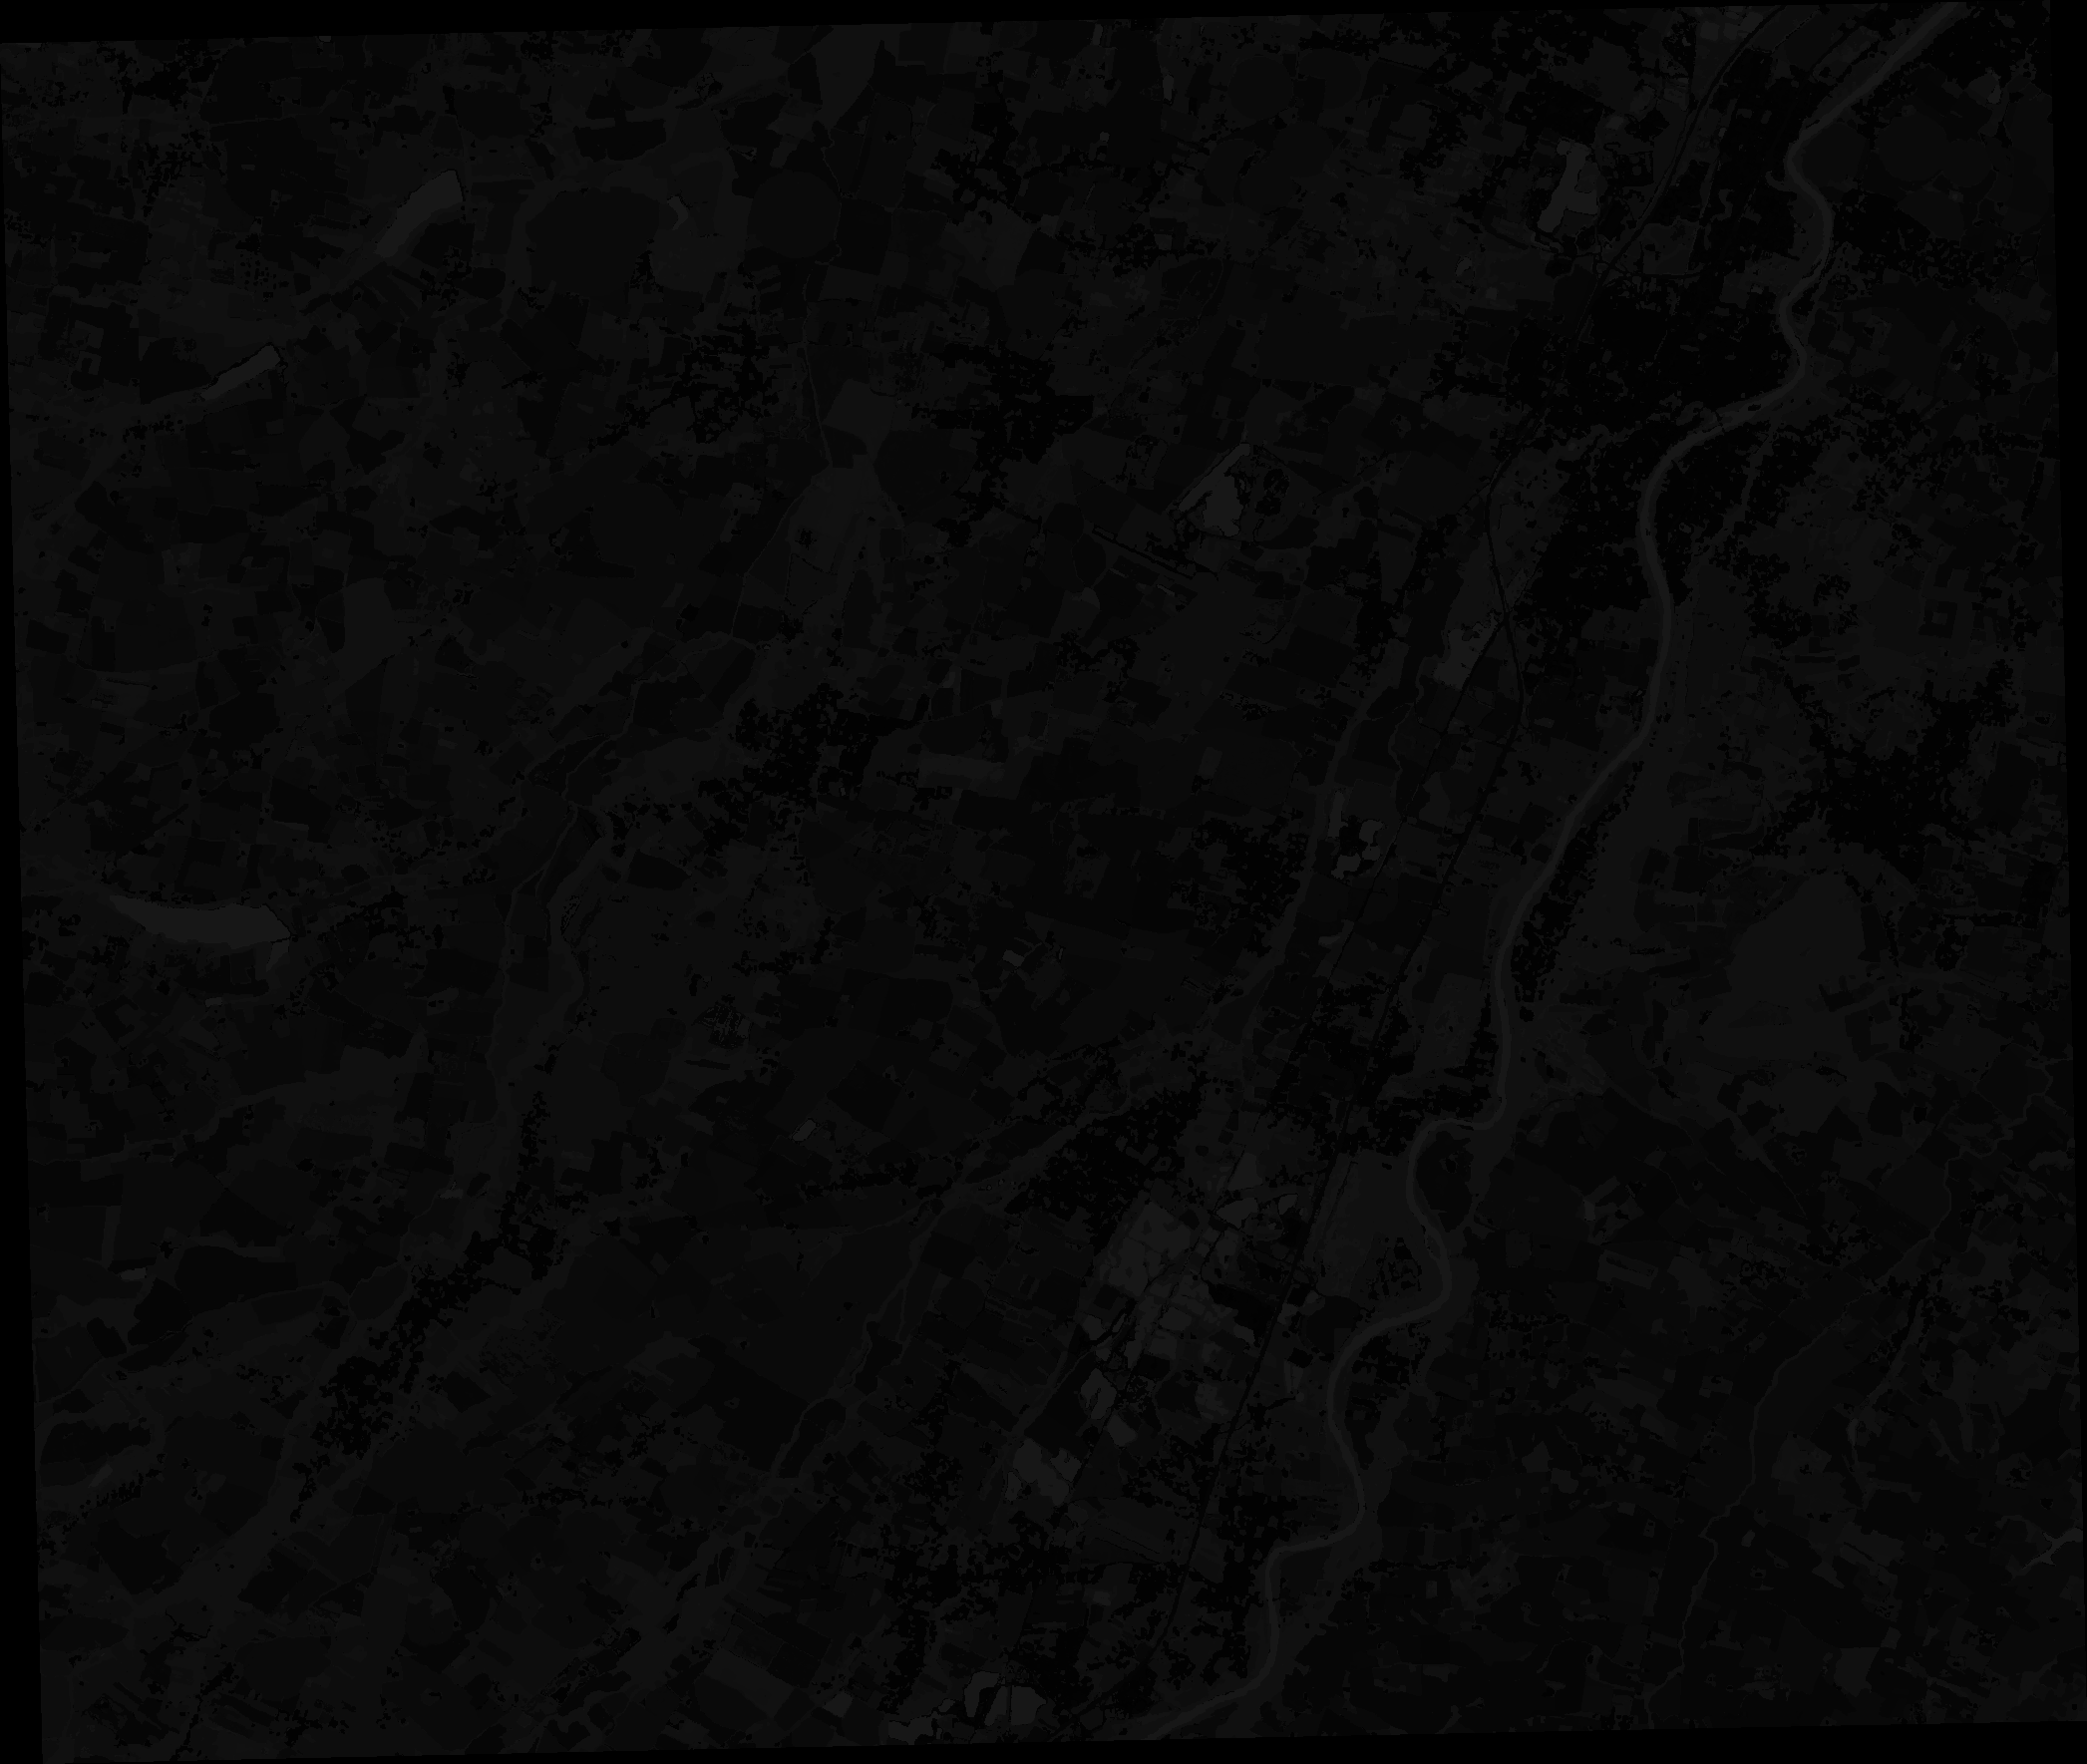

In [24]:
import pandas as pd
import folium
import geopandas as gpd
from branca.colormap import linear
from folium import plugins
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.pyplot as pyplt
from matplotlib import cm

# Read the data into a pandas DataFrame
data = gpd.read_file(os.path.join(output_directory, "polygons.json")).to_crs(epsg=4326)

# Read the raster data
raster_path = os.path.join(data_directory, "raster.png")

# ATTENTION, Folium supporte pas les majuscule, en tous cas il arrive pas à faire le lien en utilisant id s'il est en majuscule
data = data.rename(columns=lambda x: x.lower())

# Calculate the bounding box of the polygons
min_lon, min_lat, max_lon, max_lat = data.total_bounds

# Calculate the center of the bounding box
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

# Create a folium map object and set the initial location and zoom level
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)


# Add a choropleth layer to the map
folium.Choropleth(
    geo_data=data.geometry,
    name='choropleth',
    data=data.class_diversity,
    columns=['id', 'class_diversity'],
    key_on='id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Class diversity index'
).add_to(m)

# Define the color scheme for the VECTOR choropleth map
colormap = linear.YlGn_09.scale(
    data['class_diversity'].min(),
    data['class_diversity'].max())


# Define the color scheme for the choropleth map
colormap = LinearColormap(['yellow', 'green'], vmin=0, vmax= 0.09019608)

# Generate a list of colors for the colormap based on the unique values in the raster array
raster_array = pyplt.imread(raster_path)
unique_values = np.unique(raster_array)
colors = [colormap(x) for x in np.linspace(0, 1, len(unique_values))]


# Create a function to map the raster values to colors
def get_color(value):
    if value in unique_values:
        index = np.where(unique_values == value)[0][0]
        return colors[index]
    else:
        return 'transparent'

# Define colormap
colormap = {
    0: 'white',  # class 0 will be displayed as white
    1: 'blue',   # class 1 will be displayed as blue
    2: 'green',  # class 2 will be displayed as green
    3: 'red'     # class 3 will be displayed as red
}
# Add the raster layer to the map
folium.raster_layers.ImageOverlay(
    image=raster_path,
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    opacity=1,
    colormap= lambda x: get_color(x),
    origin='upper'
).add_to(m)


# Add a legend to the map
folium.LayerControl().add_to(m)

# Show the map
m


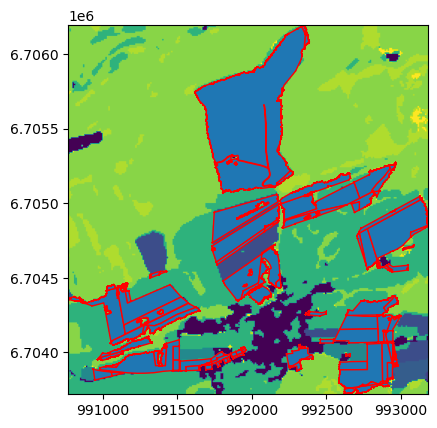

In [32]:
from rasterio.plot import show
from matplotlib import pyplot

src = rasterio.open(os.path.join(data_directory, "oso_2021_2_2154.tif"))
rail = gpd.read_file(os.path.join(output_directory, "polygons.json"))
fig, ax = pyplot.subplots()
base = show(src, ax=ax)
rail.plot(ax=ax, edgecolor="red");

In [26]:
## On souhaite pouvoir extraire des centroids de cellule Raster ainsi que le digital number et les ecrire dans un fichier

import rasterio.features
import numpy as np
from shapely.geometry import shape, Point
import fiona
from shapely import geometry

# Load the raster data
with rasterio.open(os.path.join(data_directory, "oso_2021_4326.tif")) as src:
    array = src.read(1)
    transform = src.transform

nodata_value = 0

# Create a list of points from the raster cells
points = []
# Add a point to the points list
for i, j in np.ndindex(array.shape):
    # Add a point to the points list
    if array[i, j] != nodata_value:
        # Get the coordinates of the cell center
        x, y = rasterio.transform.xy(transform, i , j )
        cell_value = array[i, j]
        points.append(Point(x, y, int(cell_value)))

# Write the points to a shapefile
schema = {'geometry': 'Point', 'properties': {'cell_value': 'int'}}
with fiona.open(os.path.join(output_directory, "points.shp"), 'w', 'ESRI Shapefile', schema, crs='epsg:4326') as output:

    # Write the points to the output file.

    for p in points:
        output.write({'geometry': geometry.mapping(p), 'properties': {'cell_value': p.z}})


KeyboardInterrupt: 

In [18]:
## Folium ne supporte pas bien les .tif , ici on convertit un tif en png, ça passe mieux
from PIL import Image

# Open the tiff file
im = Image.open(os.path.join(data_directory, "oso_2021_4326.tif"))

# Convert the tiff file to png
im.save("raster.png", "png")

In [12]:
import fiona; fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}